In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PotatoDisease",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Visualize the Images

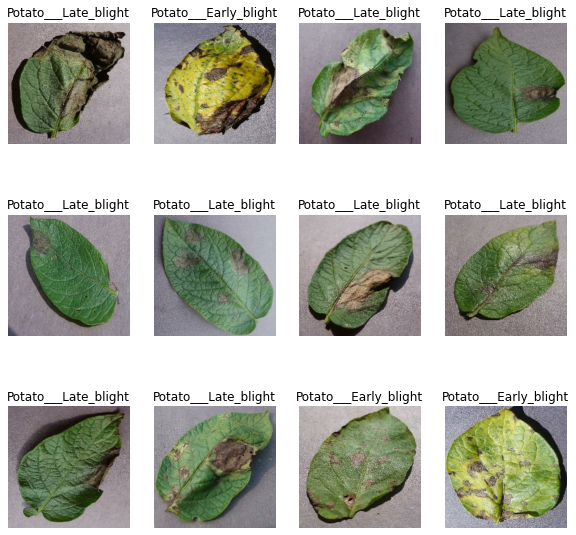

In [6]:
plt.figure(figsize = (10,10))
for image, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label[i]])
    

### Train Test Split

In [7]:
def get_dataset_partition(dataset, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(dataset)
    
    if shuffle:
        dataset.shuffle(shuffle_size, seed = 12)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
   
    train_set = dataset.take(train_size)
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)
    
    return train_set, val_set, test_set



In [8]:
train_set, val_set, test_set = get_dataset_partition(dataset)

In [9]:
len(train_set)

54

### Optimizing the datasets

Prefetch is more useful in GPUs and chaching is useful in order to decrease the idol time of CPU. 

In [10]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Setting up the Preprocessing Pipeline

In [11]:
resize_and_rescale = tf.keras.Sequential(
[    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)]
)

In [12]:
data_augmentation = tf.keras.Sequential(
[    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")]
)

### Model Building

In [13]:
input_shape = [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS]
n_classes = 3

model = models.Sequential(
[   
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape=input_shape ),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')   
]
)

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_set,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_set,
    verbose=1
)

Epoch 1/30
54/54 [==============================] - 203s 3s/step - loss: 0.9206 - accuracy: 0.4566 - val_loss: 0.8274 - val_accuracy: 0.5312
Epoch 2/30
54/54 [==============================] - 184s 3s/step - loss: 0.7184 - accuracy: 0.6400 - val_loss: 0.6214 - val_accuracy: 0.7135
Epoch 3/30
54/54 [==============================] - 188s 3s/step - loss: 0.4820 - accuracy: 0.7865 - val_loss: 0.4416 - val_accuracy: 0.8229
Epoch 4/30
54/54 [==============================] - 189s 4s/step - loss: 0.3385 - accuracy: 0.8547 - val_loss: 0.4294 - val_accuracy: 0.8229
Epoch 5/30
54/54 [==============================] - 189s 3s/step - loss: 0.2669 - accuracy: 0.8895 - val_loss: 0.2736 - val_accuracy: 0.9062
Epoch 6/30
54/54 [==============================] - 624s 12s/step - loss: 0.2313 - accuracy: 0.9074 - val_loss: 0.3478 - val_accuracy: 0.8802
Epoch 7/30
54/54 [==============================] - 184s 3s/step - loss: 0.2059 - accuracy: 0.9109 - val_loss: 0.2301 - val_accuracy: 0.9010
Epoch 8/30
5

In [17]:
scores = model.evaluate(test_set)

8/8 [==============================] - 16s 852ms/step - loss: 0.1305 - accuracy: 0.9612


In [18]:
scores

[0.13049383461475372, 0.9612069129943848]

### Model Saving

In [22]:
import os
version = max([int(i) for i in os.listdir("models") + [0]]) + 1
model.save(f"models/{version}")

INFO:tensorflow:Assets written to: models/1\assets


### Visualizing the metrics

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
loss = history.history['loss']

Text(0.5, 1.0, 'Training v Val Accuracy')

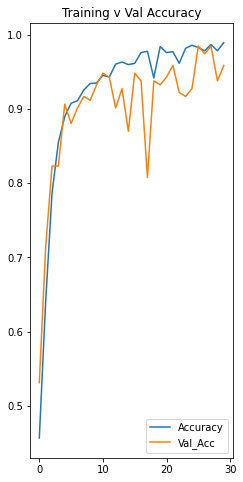

In [25]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Val_Acc')
plt.legend(loc = 'lower right')
plt.title("Training v Val Accuracy")

### Prediction

Potato___Late_blight
[1.4337095e-02 9.8566276e-01 6.4958009e-08]


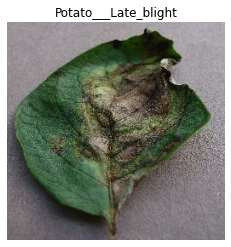

In [26]:
import numpy as np
for image, label in dataset.take(1):
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.axis('off')
    label = class_names[label[0]]
    plt.title(label)
    
    pred_label = class_names[np.argmax(model.predict(image)[0])]
    print(pred_label)
    print(model.predict(image)[0])

In [27]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]*100), 2)
    
    return predicted_class, confidence


# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = model.predict(img_array)

#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence

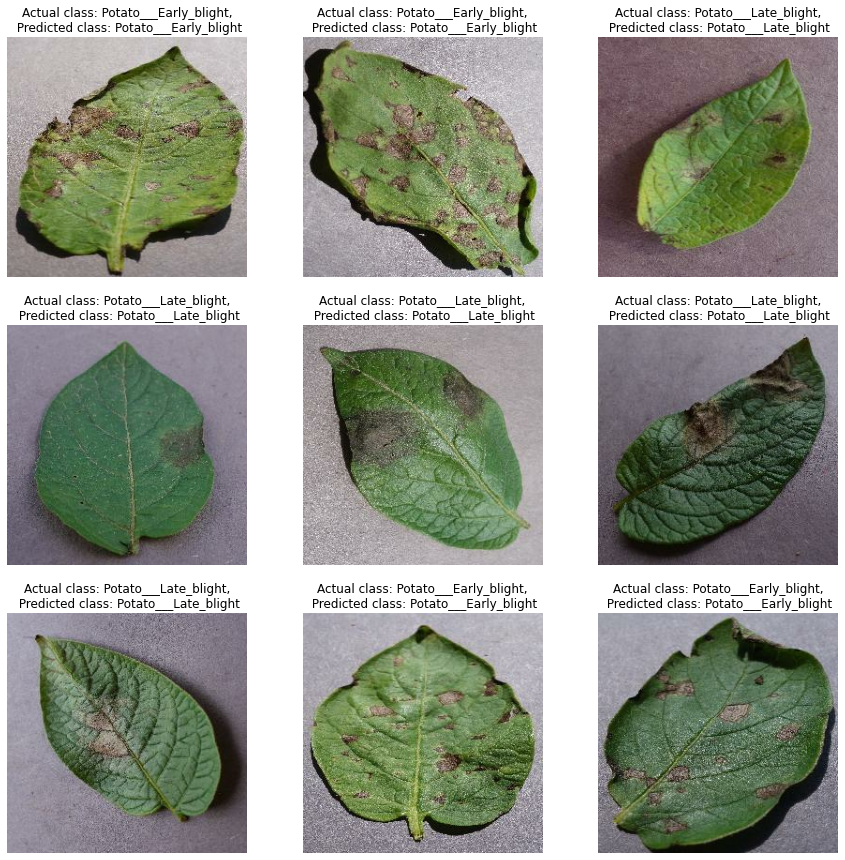

In [28]:
plt.figure(figsize=(15,15))

for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual class: {actual_class},\n Predicted class: {predicted_class}")
        
        plt.axis('off')
            
#         ax = plt.subplot(3,3, i+1)
        
#         first_Image = image[i].numpy().astype('uint8')
#         first_label = class_names[label[i]]
        
#         predict_class = predict(model, image[i].numpy())
#         confidence = predict_class[1]*100
        
#         plt.imshow(first_Image)
#         plt.axis('off')
        
#         title = f"Actual label: {first_label},\n Predicted label: {predict_class[0]},\n Confidence: {confidence}"
#         plt.title(title)